In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Review

### System of Linear Equations Exact Solver

$$ \begin{bmatrix} 1 & 2 \\ -3 & 4 \end{bmatrix} \left[ \begin{array}{c} x_1 \\ x_2 \end{array} \right] = \left[ \begin{array}{cc} 7 \\ -9 \end{array} \right] $$

In [2]:
A = np.array([[1, 2], [-3, 4]])
b = np.array([7, -9])

print np.linalg.solve(A, b)

[ 4.6  1.2]


### Least Squares Solver

What if we have an overdetermined system of linear equations? E.g.

$$ \begin{bmatrix} 1 & 2 \\ -3 & 4 \\ 1 & -4 \end{bmatrix} \left[ \begin{array}{c} x_1 \\ x_2 \end{array} \right] = \left[ \begin{array}{cc} 7 \\ -9 \\ 17 \end{array} \right] $$

An exact solution is not guaranteed, so we must do something else. Least Squares dictates that we find the $x$ that minimizes the residual sum of squares (RSS).

(Note: This is the solver we use when doing Linear Regression!)

In [3]:
A = np.array([[1, 2], [-3, 4], [1, -4]])
b = np.array([7, -9, 17])

print np.linalg.lstsq(A, b)[0]

[ 2.88 -1.38]


### Non-negative Least Squares Solver

What if you want to constrain the solution to be non-negative? (Doing such a thing will be important to us today.)

We have optomizers for that too!

**NOTE**: [This](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.nnls.html) function will only work when `b` is a vector, not a matrix.  So this will unfortunately not work for our purposes today.

In [4]:
from scipy.optimize import nnls

A = np.array([[1, 2], [-3, 4], [1, -4]])
b = np.array([7, -9, 17])

print nnls(A, b)[0]

[ 4.63636364  0.        ]


### Numpy Least Squares

For this afternoon we will be using [Numpy's Least Squares Solver](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html).  This allows us to solve the problem `ax = b` where where `x = np.linalg.lstsq(a, b)`

In [5]:
A = np.array([[1, 2]])
b = np.array([[7, -9, 17]])

x = np.linalg.lstsq(A, b)[0]

print(x)
print('\nMatrix after being clipped:')
print(x.clip(min=0))

[[ 1.4 -1.8  3.4]
 [ 2.8 -3.6  6.8]]

Matrix after being clipped:
[[ 1.4  0.   3.4]
 [ 2.8  0.   6.8]]


## Problems with SVD for topic analysis

**Recall:** $M = U S V^T$

* Values in $U$ and $V^T$ can be negative, which is weird and hard to interpret. For example, suppose a latent feature is the genre 'Sci-fi'. This feature can be positive (makes sense), zero (makes sense), or negative (what does that mean?).

* SVD forces us to fill in missing values, then SVD models those missing values, which is bad.

Today we're going to cover NMF, which will address the first issue. Tomorrow afternoon we'll discuss how to address the second issue.

## NMF for topic analysis

### Example

Let's look at users ratings of different movies. The ratings are from 1-5. A rating of 0 means the user hasn't watched the movie.

|              | Matrix | Alien | Spaceballs | Casablanca | Titanic |
|:------------:|:------:|:-----:|:----------:|:----------:|:-------:|
|  **Lance**   |   1    |   2   |     2      |     0      |    0    |
|   **Jan**    |   3    |   5   |     5      |     0      |    0    |
|    **JP**    |   4    |   4   |     4      |     0      |    0    |
| **Gretchen** |   5    |   5   |     5      |     0      |    0    |
|  **Kayla**   |   0    |   2   |     0      |     4      |    4    |
|  **Frank**   |   0    |   0   |     0      |     5      |    5    |
|   **Adam**   |   0    |   1   |     0      |     2      |    2    |

Note that the first three movies (Matrix, Alien, StarWars) are Sci-fi movies and the last two (Casablanca, Titanic) are Romance. We will be able to mathematically pull out these topics!

In [6]:
M = np.array([[1, 2, 2, 0, 0],
              [3, 5, 5, 0, 0],
              [4, 4, 4, 0, 0],
              [5, 5, 5, 0, 0],
              [0, 2, 0, 4, 4],
              [0, 0, 0, 5, 5],
              [0, 1, 0, 2, 2]])

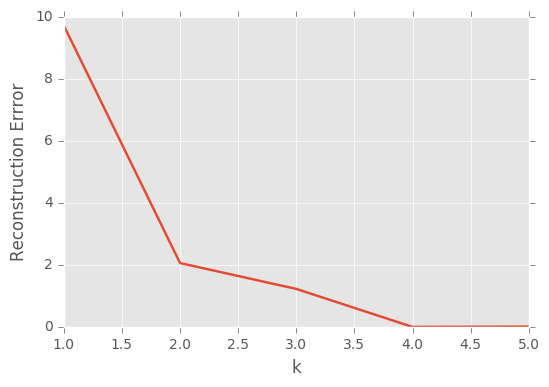

In [8]:
# Compute NMF
from sklearn.decomposition import NMF

def fit_nmf(k):
    nmf = NMF(n_components=k)
    nmf.fit(M)
    W = nmf.transform(M)
    H = nmf.components_
    return nmf.reconstruction_err_

error = [fit_nmf(i) for i in range(1,6)]
plt.plot(range(1,6), error)
plt.xlabel('k')
plt.ylabel('Reconstruction Errror');

In [9]:
# Fit using 3 hidden concepts
nmf = NMF(n_components=3)
nmf.fit(M)
W = nmf.transform(M)
H = nmf.components_
print 'RSS = {:.2f}'.format(nmf.reconstruction_err_)

RSS = 1.23


In [10]:
# Make interpretable
movies = ['Matrix','Alien','Spaceballs','Casablanca','Titanic']
users = ['Lance', 'Jan', 'JP', 'Gretchen', 'Kayla', 'Frank', 'Adam']

W, H = (np.around(x,2) for x in (W,H))
W = pd.DataFrame(W,index=users)
H = pd.DataFrame(H,columns=movies)

print(W)
print('\n')
print(H)

             0     1     2
Lance     0.70  0.00  0.21
Jan       1.73  0.00  0.61
JP        1.29  0.00  0.76
Gretchen  1.62  0.00  0.95
Kayla     0.39  1.84  0.00
Frank     0.00  2.28  0.00
Adam      0.20  0.92  0.00


   Matrix  Alien  Spaceballs  Casablanca  Titanic
0    0.00   3.02        1.85        0.00     0.00
1    0.00   0.20        0.00        2.19     2.19
2    5.21   0.00        2.31        0.00     0.00


In [11]:
# Verify reconstruction
print(np.around(W.dot(H),1))
print('\n')
print(pd.DataFrame(M, index=users, columns=movies))

          Matrix  Alien  Spaceballs  Casablanca  Titanic
Lance        1.1    2.1         1.8         0.0      0.0
Jan          3.2    5.2         4.6         0.0      0.0
JP           4.0    3.9         4.1         0.0      0.0
Gretchen     4.9    4.9         5.2         0.0      0.0
Kayla        0.0    1.5         0.7         4.0      4.0
Frank        0.0    0.5         0.0         5.0      5.0
Adam         0.0    0.8         0.4         2.0      2.0


          Matrix  Alien  Spaceballs  Casablanca  Titanic
Lance          1      2           2           0        0
Jan            3      5           5           0        0
JP             4      4           4           0        0
Gretchen       5      5           5           0        0
Kayla          0      2           0           4        4
Frank          0      0           0           5        5
Adam           0      1           0           2        2


In [12]:
# Compare to SVD
from numpy.linalg import svd
k = 3

# Compute SVD
U, sigma, VT = svd(M)

# Make pretty
U, sigma, VT = (np.around(x,2) for x in (U,sigma,VT))
U = pd.DataFrame(U, index=users)
VT = pd.DataFrame(VT, columns=movies)

# Keep top three concepts
U = U.iloc[:,:k]
sigma = sigma[:k]
VT = VT.iloc[:k,:]

print(U)
print('\n')
print(sigma)
print('\n')
print(VT)

             0     1     2
Lance    -0.21  0.02  0.31
Jan      -0.55  0.06  0.53
JP       -0.50  0.07 -0.31
Gretchen -0.62  0.08 -0.39
Kayla    -0.12 -0.60  0.40
Frank    -0.04 -0.73 -0.42
Adam     -0.06 -0.30  0.20


[ 13.84   9.52   1.69]


   Matrix  Alien  Spaceballs  Casablanca  Titanic
0   -0.50  -0.62       -0.60       -0.06    -0.06
1    0.09  -0.05        0.11       -0.70    -0.70
2   -0.78   0.62        0.03       -0.07    -0.07


## Interpreting Concepts
#### Think of NMF like 'fuzzy clustering'
- The concepts are clusters
- Each row (document, user, etc...) can belong to more than one concept

#### Top Questions:
1. What do the concepts (clusters) mean?
2. To which concept(s) does each user/document belong?

#### What is concept 0?

In [13]:
# Top 2 movies in genre 0
top_movies = H.iloc[0, :].sort_values(ascending=False).index[:2]
top_movies

Index([u'Alien', u'Spaceballs'], dtype='object')

#### Which users align with concept 0?

In [14]:
# Top 2 users for genre 0
top_users = W.iloc[:,0].sort_values(ascending=False).index[:2]
top_users

Index([u'Jan', u'Gretchen'], dtype='object')

#### What concepts does Kayla align with?

In [15]:
W.loc['Kayla']

0    0.39
1    1.84
2    0.00
Name: Kayla, dtype: float64

#### What are all the movies in each concept?

In [16]:
# Number of movies in each concept
thresh = .2  # movie is included if at least 20% of max weight
for g in range(3):
    all_movies = H.iloc[g,:]
    included = H.columns[all_movies >= (thresh * all_movies.max())]
    print "Concept {} contains: {}".format(g, ', '.join(included))

Concept 0 contains: Alien, Spaceballs
Concept 1 contains: Casablanca, Titanic
Concept 2 contains: Matrix, Spaceballs


#### Which users are associated with each concept?

In [17]:
# Users in each concept
thresh = .2  # user is included if at least 20% of max weight
for g in range(3):
    all_users = W.iloc[:,g]
    included = W.index[all_users >= (thresh * all_users.max())]
    print "Concept %i contains: %s" % (g, ', '.join(included))

Concept 0 contains: Lance, Jan, JP, Gretchen, Kayla
Concept 1 contains: Kayla, Frank, Adam
Concept 2 contains: Lance, Jan, JP, Gretchen
